### 1. 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. 데이터 불러오기 / 살펴보기

In [17]:
birth = pd.read_csv('/content/drive/MyDrive/birth.csv')

In [18]:
birth

,time,newborn
0,1981. 01,88151
1,1981. 02,93556
2,1981. 03,70421
3,1981. 04,66093
4,1981. 05,68940
...,...,...
471,2020. 04 p),23420
472,2020. 05 p),23001
473,2020. 06 p),22193
474,2020. 07 p),23067


Text(0.5, 1.0, 'number of newborn')

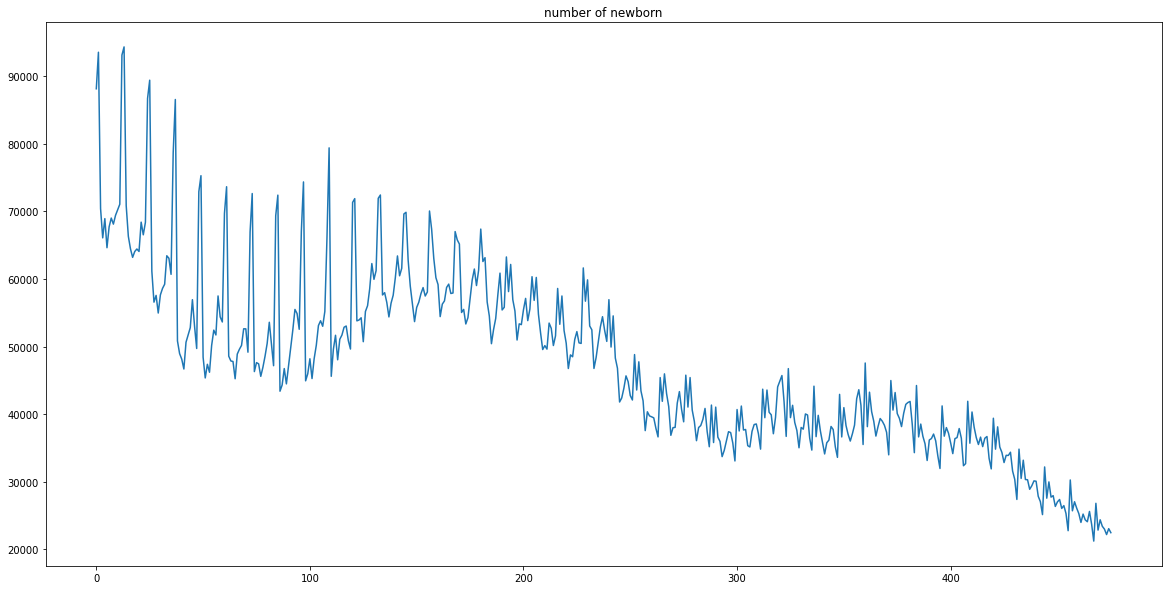

In [19]:
plt.figure(figsize=(20,10))
plt.plot(birth['newborn'])
plt.title('number of newborn')

### 2.5 데이터 전처리

In [279]:
birth = birth.drop(['time'], axis=1)

In [7]:
np.random.seed(2016122032)

In [8]:
dataset = birth.values
dataset = dataset.astype('float32')

In [9]:
# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [10]:
# split data into train / test
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train_data), len(test_data))

380 96


In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t and Y=t+12
look_back = 12
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (367, 12)
y_train.shape:  (367,)
X_test.shape:  (83, 12)
y_test.shape:  (83,)


In [13]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (367, 1, 12)
y_train.shape:  (367,)
X_test.shape:  (83, 1, 12)
y_test.shape:  (83,)


### 3. 필요한 함수들 정의

In [40]:
# make & invert prediction & calculate root mean squared error
def prediction(model,X_train, y_train, X_test, y_test):
    
    global train_predict, test_predict, Y_train2, Y_test2
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
  
    train_predict = scaler.inverse_transform(train_predict)
    Y_train2 = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test2 = scaler.inverse_transform([y_test])

    #  test prediction plot
    test_predict2 = test_predict.flatten()
    Y_test22 = Y_test2.flatten()

    plt.plot(Y_test22)
    plt.plot(test_predict2)
    plt.legend(['True','Test_predict'], loc='upper right', fontsize=10)
    plt.show()

    trainScore = math.sqrt(mean_squared_error(Y_train2[0], train_predict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(Y_test2[0], test_predict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

In [15]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.title('Model Train Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss'], loc='upper right')

### 4. 모델 정의

In [266]:
# create the rnn network
def single_RNN(n, d):
  model = Sequential()
  model.add(SimpleRNN(n, input_shape=(1, look_back)))
  model.add(Dropout(d))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def double_RNN(n1, n2, d):
  model = Sequential()
  model.add(SimpleRNN(n1, input_shape=(1, look_back), return_sequences=True))
  model.add(Dropout(d))
  model.add(SimpleRNN(n2))
  model.add(Dropout(d))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model 

 # create the LSTM network
def single_LSTM(n, d):
  model = Sequential()
  model.add(LSTM(n, input_shape=(1, look_back)))
  model.add(Dropout(d))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss='mean_squared_error', optimizer='rmsprop')
  return model

def double_LSTM(n1, n2, d):
  model = Sequential()
  model.add(LSTM(n1, input_shape=(1, look_back), return_sequences=True))
  model.add(Dropout(d))
  model.add(LSTM(n2))
  model.add(Dropout(d))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss='mean_squared_error', optimizer='rmsprop')
  return model

# create the GRU network
def single_GRU(n, d):
  model = Sequential()
  model.add(GRU(n, input_shape=(1, look_back)))
  model.add(Dropout(d))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def double_GRU(n1, n2, d):
  model = Sequential()
  model.add(GRU(n1, input_shape=(1, look_back), return_sequences=True))
  model.add(Dropout(d))
  model.add(GRU(n2))
  model.add(Dropout(d))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model    

### Simple RNN

#### single rnn

In [34]:
rnn1 = single_RNN(50,0.2)
history1 = rnn1.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1)
rnn1.summary()

Epoch 1/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0670
Epoch 2/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0336
Epoch 3/25
37/37 [==============================] - 0s 1ms/step - loss: 0.0270
Epoch 4/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0233
Epoch 5/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 6/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 7/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 8/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 9/25
37/37 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 10/25
37/37 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 11/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 12/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0058
Epoch 13/25
37/37 [==============================

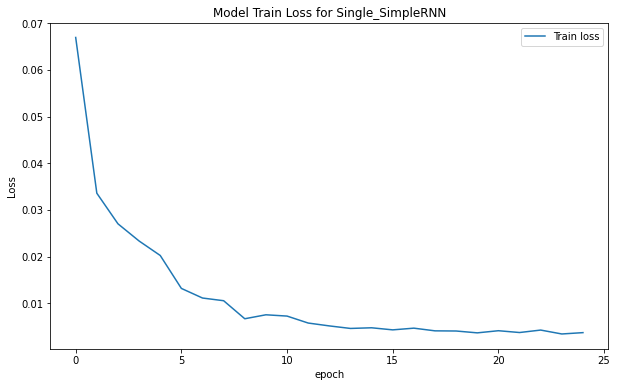

In [35]:
plot_loss(history1, 'Single_SimpleRNN')

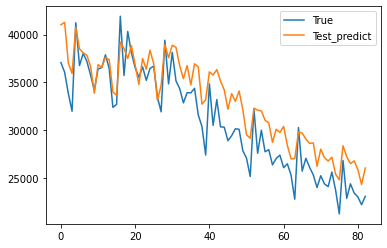

Train Score: 3228.22 RMSE
Test Score: 2796.69 RMSE


In [41]:
prediction(rnn1, X_train, y_train, X_test, y_test)

#### double rnn

In [42]:
rnn2 = double_RNN(50,50,0.2)
history2 = rnn2.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1)
rnn2.summary()

Epoch 1/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0956
Epoch 2/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 3/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0338
Epoch 4/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 5/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 6/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 7/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 8/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 9/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 10/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 11/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 12/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 13/25
37/37 [==============================

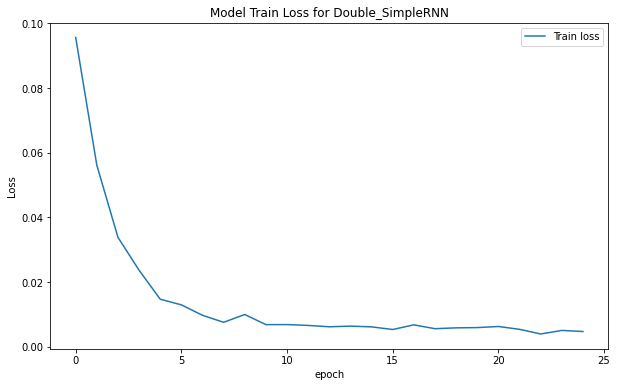

In [43]:
plot_loss(history2, 'Double_SimpleRNN')

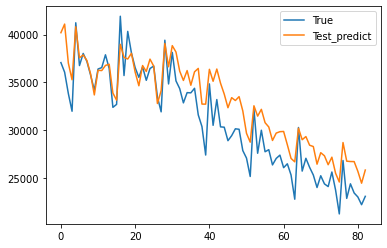

Train Score: 3198.95 RMSE
Test Score: 2570.38 RMSE


In [44]:
prediction(rnn2, X_train, y_train, X_test, y_test)

### LSTM

#### single lstm

In [77]:
lstm1 = single_LSTM(55,0.2)
history3 = lstm1.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1)
lstm1.summary()

Epoch 1/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 2/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 3/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0081
Epoch 4/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 5/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 6/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 7/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 8/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 9/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 10/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 11/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 12/25
37/37 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 13/25
37/37 [==============================

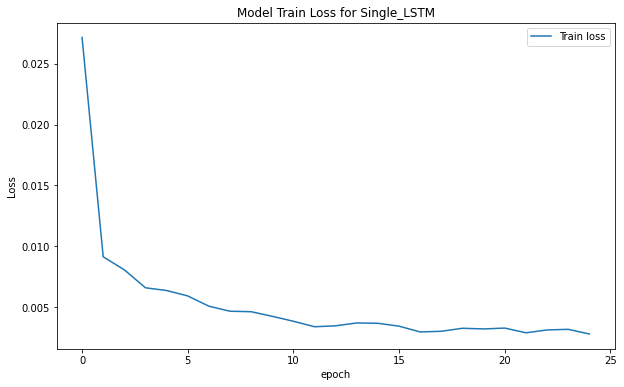

In [78]:
plot_loss(history3, 'Single_LSTM')

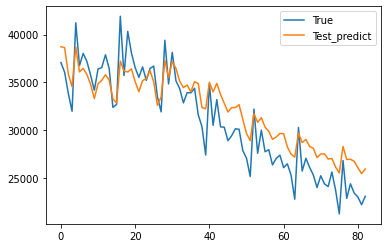

Train Score: 4118.69 RMSE
Test Score: 2384.84 RMSE


In [79]:
prediction(lstm1, X_train, y_train, X_test, y_test)

#### double lstm

In [220]:
lstm2 =  double_LSTM(50,55,0.2)
history4 = lstm2.fit(X_train, y_train, epochs=50, batch_size=10, verbose=1)
lstm2.summary()

Epoch 1/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0404
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 5/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0078
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0078
Epoch 7/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 10/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 11/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 12/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 13/50
37/37 [==============================

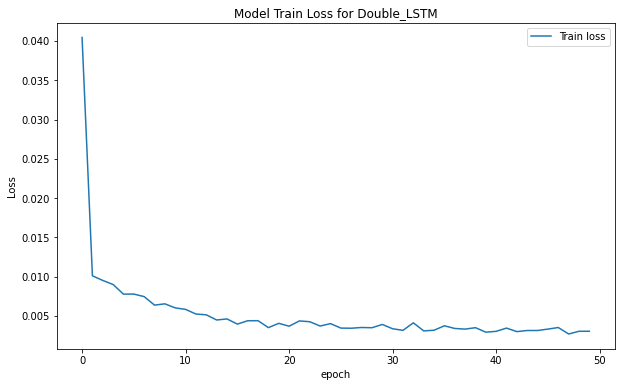

In [221]:
plot_loss(history4, 'Double_LSTM')

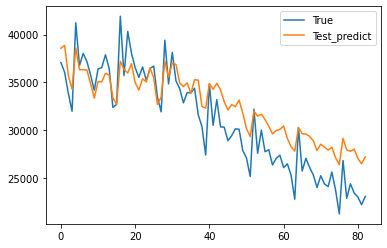

Train Score: 4358.09 RMSE
Test Score: 2797.68 RMSE


In [222]:
prediction(lstm2, X_train, y_train, X_test, y_test)

### GRU

#### single gru

In [235]:
gru1 = single_GRU(50,0.2)
history5 = gru1.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1)
gru1.summary()

Epoch 1/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 2/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 3/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 4/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 5/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 6/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 7/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 8/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 9/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 10/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 11/25
37/37 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 12/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 13/25
37/37 [==============================

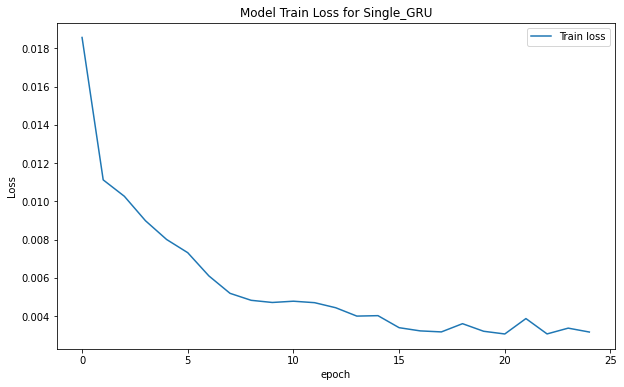

In [236]:
plot_loss(history5, 'Single_GRU')

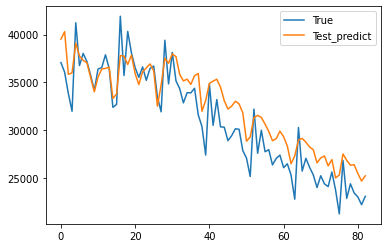

Train Score: 3305.24 RMSE
Test Score: 2463.81 RMSE


In [237]:
prediction(gru1, X_train, y_train, X_test, y_test)

#### double gru

In [273]:
gru2 = double_GRU(50,50,0.2)
history6 = gru2.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1)
gru2.summary()

Epoch 1/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0284
Epoch 2/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 3/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 4/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0079
Epoch 5/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 6/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 7/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 8/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 9/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 10/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 11/25
37/37 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 12/25
37/37 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 13/25
37/37 [==============================

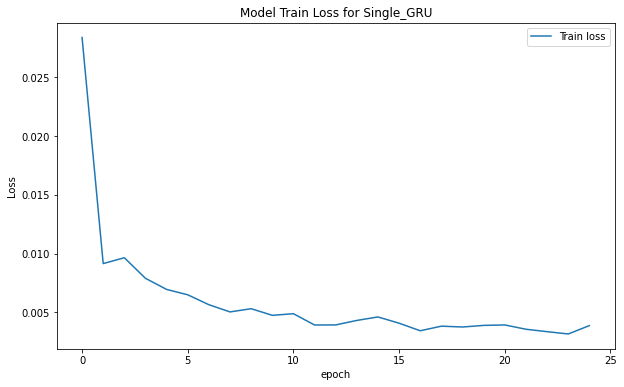

In [274]:
plot_loss(history6, 'Single_GRU')

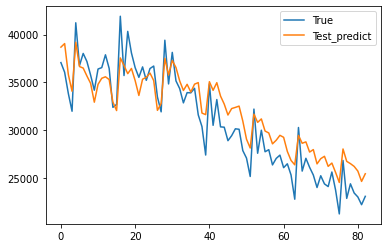

Train Score: 3680.77 RMSE
Test Score: 2157.15 RMSE


In [275]:
prediction(gru2, X_train, y_train, X_test, y_test)

### SRIMA

In [286]:
import itertools
import statsmodels.api as sm

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [295]:
result1 = pd.DataFrame(data = {'De_Seasonal' : [(0,0,0)], 'Seasonal' : [(0,0,0)], 'AIC' : [10000]}, columns = ['De_Seasonal', 'Seasonal', 'AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(birth['newborn'],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            result2 = pd.DataFrame(data = {'De_Seasonal' : [param], 'Seasonal' : [param_seasonal], 'AIC' : results.aic}, columns = ['De_Seasonal', 'Seasonal', 'AIC'])
            result1 = pd.concat([result1, result2], axis =0, join = 'outer')
        except: 
            continue

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [306]:
result1[result1['AIC'] == min(result1['AIC'])]

,De_Seasonal,Seasonal,AIC
0,"(0, 1, 1)","(0, 1, 1, 12)",8088.486149


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4511      0.037    -12.177      0.000      -0.524      -0.379
ma.S.L12      -0.2767      0.022    -12.485      0.000      -0.320      -0.233
sigma2      4.221e+06   2.13e+05     19.831      0.000     3.8e+06    4.64e+06


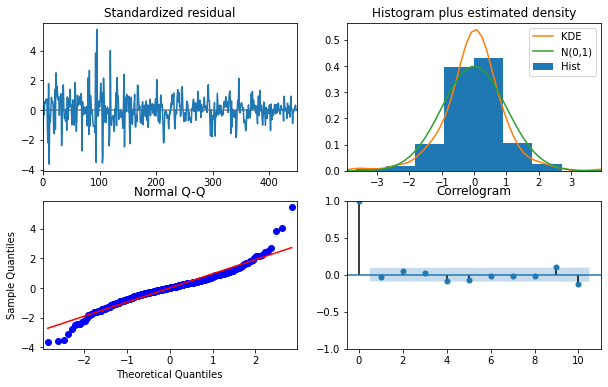

In [323]:
mod = sm.tsa.statespace.SARIMAX(birth['newborn'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
res = mod.fit()
print(res.summary().tables[1])

res.plot_diagnostics(figsize = (10,6))
plt.show()

Test RMSE is 3051.0280164861965


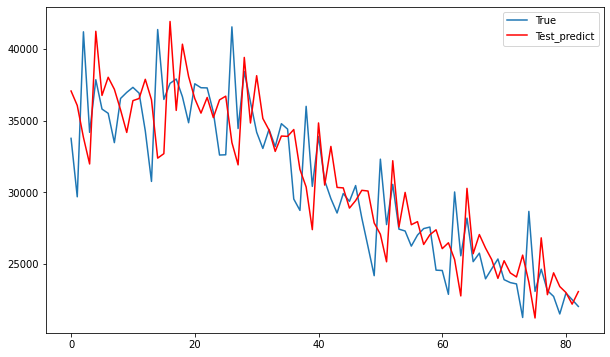

In [321]:
pred = res.get_prediction(start = 394, end = 476, dynamic = False)
#y_pred = pred.predicted_mean
y_pred = pred.predicted_mean
print('Test RMSE is', np.sqrt(mean_squared_error(Y_test22, y_pred)))

plt.figure(figsize = (10,6))
x1 = np.arange(0, 83)
plt.plot( x1, y_pred, x1, Y_test22, 'r-')
plt.legend(['True','Test_predict'], loc='upper right', fontsize=10)
plt.show()